In [1]:
import string
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [2]:
characters = string.ascii_letters + string.digits + string.punctuation

In [3]:
def transform(image):
    width , height = image.shape

    new_width = 32
    new_height = int(height * (new_width / width))
    image = cv2.resize(image, (new_height , new_width))
    image = image.astype('float32')
    width , height = image.shape

    if width < 32:
        add_zeros = np.full((32-width, height), 255)
        image = np.concatenate((image, add_zeros))
        width , height = image.shape

    if height < 128:
        add_zeros = np.full((width , 128-height), 255)
        image = np.concatenate((image, add_zeros), axis=1)
        width , height = image.shape

    if height > 128 or width > 32:
        dim = (128,32)
        image = cv2.resize(image, dim)

    image = cv2.subtract(255, image)
    # Expanding the dimension of image
    image = np.expand_dims(image, axis=2)
    # Normalize the image
    image = image / 255
    return image

In [4]:
inputs = Input(shape=(32,128,1))
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1) 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4) 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(characters)+1, activation = 'softmax')(blstm_2)

enigma = Model(inputs, outputs)

In [5]:
enigma.load_weights('models/model-30e-Adamo.h5')

pickeed

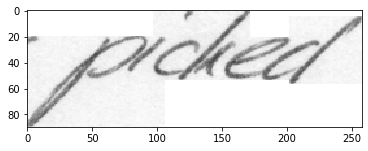

In [6]:
vali_im = cv2.imread('words/a02/a02-000/a02-000-00-03.png')
vali_img = cv2.imread('words/a02/a02-000/a02-000-00-03.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(vali_im)

vali_img = transform(vali_img)
vali_img = np.asarray(vali_img)
vali_img = np.expand_dims(vali_img,axis=0)

vali_img.shape

# predict outputs on validation images
prediction =enigma.predict(vali_img)
# use CTC decoder
decoded = K.ctc_decode(prediction,input_length=np.ones(prediction.shape[0]) * prediction.shape[1],greedy=True)[0][0]
output = K.get_value(decoded)

for i, x in enumerate(output):
    for p in x:
        if int(p) != -1:
            print(characters[int(p)],end='')
    break